# Chapter 5 - Text Clustering and Topic Modeling

## ArXiv Articles: Computation and Language

In [1]:
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

## A Common Pipeline for Text Clustering

### 1. Embedding Documents

In [2]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

d:\Anaconda\envs\LLMs-env\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\PC\.cache\huggingface\hub\models--thenlper--gte-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

d:\Anaconda\envs\LLMs-env\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [3]:
embeddings.shape

(44949, 384)

### 2. Reducing the Dimensionality of Embeddings

In [4]:
from umap import UMAP

umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

d:\Anaconda\envs\LLMs-env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### 3. Cluster the Reduced Embeddings

In [5]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

len(set(clusters))

162

### Inspecting the clusters

In [6]:
import numpy as np

cluster = 0
for index in np.where(clusters==cluster)[0][:3]: # print first 3 documents in cluster 0
    print(abstracts[index][:300] + '... \n')

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



In [7]:
import pandas as pd

reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)

df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]


d:\Anaconda\envs\LLMs-env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Static Plot

(-9.622177839279175,
 11.280917882919312,
 -0.8895460952073336,
 16.165929189696907)

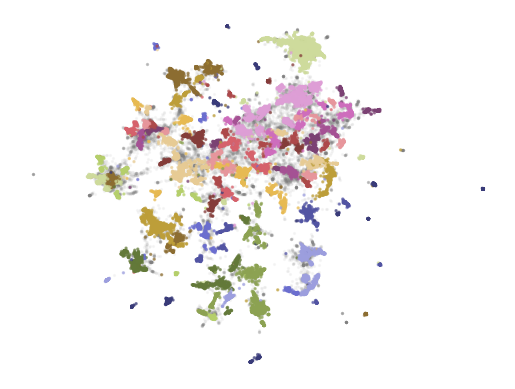

In [8]:
import matplotlib.pyplot as plt

plt.scatter(outliers_df.x, outliers_df.y, alpha=.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=.6, s=2, cmap='tab20b'
)

plt.axis('off')

## From Text Clustering to Topic Modeling

### BERTopic: A Modular Topic Modeling Framework

In [9]:
from bertopic import BERTopic

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-05-09 22:20:35,357 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-09 22:20:59,676 - BERTopic - Dimensionality - Completed ✓
2025-05-09 22:20:59,678 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-09 22:21:01,237 - BERTopic - Cluster - Completed ✓
2025-05-09 22:21:01,246 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-05-09 22:21:03,999 - BERTopic - Representation - Completed ✓


In [10]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  15015                               -1_the_of_and_to   
1        0   2171                   0_speech_asr_recognition_end   
2        1   1151          1_medical_clinical_biomedical_patient   
3        2    915               2_translation_nmt_machine_neural   
4        3    879  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
157    156     52          156_sentence_embeddings_sts_embedding   
158    157     51                157_moe_experts_mixture_routing   
159    158     50             158_table_tables_tabular_reasoning   
160    159     50      159_prompt_prompts_optimization_prompting   
161    160     50                 160_long_context_window_length   

                                        Representation  \
0    [the, of, and, to, in, we, for, that, language...   
1    [speech, asr, recognition, end, acoustic, spea...   
2    [medical, clinical, biomedical, patient, notes...   
3    [translation, nmt, machine, neural, bleu, engl...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
157  [sentence, embeddings, sts, embedding, similar...   
158  [moe, experts, mixture, routing, expert, spars...   
159  [table, tables, tabular, reasoning, column, nu...   
160  [prompt, prompts, optimization, prompting, eng...   
161  [long, context, window, length, llms, memory, ...   

                                   Representative_Docs  
0    [  Large language models (LLMs) are powerful d...  
1    [  Speech-based virtual assistants, such as Am...  
2    [  Clinical texts, such as admission notes, di...  
3    [  Neural machine translation (NMT) systems re...  
4    [  Sentence summarization shortens given texts...  
..                                                 ...  
157  [  Sentence representation at the semantic lev...  
158  [  The Mixture of Experts (MoE) models are an ...  
159  [  Table reasoning, which aims to generate the...  
160  [  Prompt optimization aims to find the best p...  
161  [  We present a series of long-context LLMs th...  

[162 rows x 5 columns]

In [11]:
topic_model.get_topic(0)

[('speech', 0.02818297040214967),
 ('asr', 0.0188698225057282),
 ('recognition', 0.013398623401770567),
 ('end', 0.009964063812810564),
 ('acoustic', 0.009586316284179894),
 ('speaker', 0.00690689691531062),
 ('audio', 0.006864089398242528),
 ('wer', 0.006418492605608615),
 ('error', 0.0064131382501455385),
 ('the', 0.006131287154930173)]

In [12]:
topic_model.find_topics("topic modeling")

([23, -1, 33, 34, 1],
 [0.95458764, 0.9123841, 0.9075248, 0.90522575, 0.9050351])

In [13]:
topic_model.get_topic(22)

[('adversarial', 0.0638207692520362),
 ('attacks', 0.03299575683995408),
 ('attack', 0.031550133594718484),
 ('robustness', 0.021630680391561338),
 ('examples', 0.01859772066758063),
 ('perturbations', 0.013454957966861731),
 ('defense', 0.011348376604530475),
 ('perturbation', 0.009153933787159884),
 ('against', 0.009002186473954033),
 ('nlp', 0.008881340550843735)]

In [14]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

23

## Visualizations

### Visualize Documents

In [15]:
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

fig.update_layout(font=dict(size=16))

In [16]:
topic_model.visualize_barchart()

topic_model.visualize_heatmap(n_clusters=30)

topic_model.visualize_hierarchy()

## Representation Models

In [17]:
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [18]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between 2 models"""
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]
    return df

### KeyBERTInspired

In [19]:
from bertopic.representation import KeyBERTInspired

representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0        speech | asr | recognition | end | acoustic   
1      1  medical | clinical | biomedical | patient | notes   
2      2        translation | nmt | machine | neural | bleu   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                             Updated  
0       phonetic | speech | voice | encoder | spoken  
1        nlp | language | clinical | text | medicine  
2  translation | translations | translate | monol...  
3  summarization | summarizers | summaries | summ...  
4    hate | hateful | language | offensive | twitter

### Maximal Marginal Relevance

In [20]:
from bertopic.representation import MaximalMarginalRelevance

representation_model = MaximalMarginalRelevance(diversity=.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

topic_differences(topic_model, original_topics)


Topic                                           Original  \
0      0        speech | asr | recognition | end | acoustic   
1      1  medical | clinical | biomedical | patient | notes   
2      2        translation | nmt | machine | neural | bleu   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                             Updated  
0           speech | asr | error | automatic | model  
1  clinical | biomedical | patient | domain | ext...  
2       translation | nmt | neural | bleu | parallel  
3  summarization | extractive | rouge | documents...  
4  offensive | toxic | abusive | hateful | platforms

## Text Generation

### Flan-T5

In [21]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, What is this topic about?"""

generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

topic_differences(topic_model, original_topics)

  0%|          | 0/162 [00:00<?, ?it/s]d:\Anaconda\envs\LLMs-env\lib\site-packages\transformers\generation\utils.py:1168: UserWarning:

Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.

100%|██████████| 162/162 [00:25<00:00,  6.45it/s]


Topic                                           Original  \
0      0        speech | asr | recognition | end | acoustic   
1      1  medical | clinical | biomedical | patient | notes   
2      2        translation | nmt | machine | neural | bleu   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                             Updated  
0             Speech-to-text Translation |  |  |  |   
1                           Science/Tech |  |  |  |   
2  Learning from a neural machine translation |  ...  
3                          Summarization |  |  |  |   
4                           Science/Tech |  |  |  |